In [1]:
import sys
sys.path.insert(0, '/Users/shiahlints/galvanize/FIXGITPROBLEM/booking-agent-ai')
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import find_nearest_venues as fnv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load the data
events is split into a tran and test set on time

In [2]:
train_events = pd.read_pickle('../data/train_events_df.p')
test_events = pd.read_pickle('../data/test_events_raw_df.p')
train_venues = pd.read_pickle('../data/train_venues_df.p')
artists = pd.read_pickle('../data/master_artists_df.p')

# Calibrate the venufinder on the events in the training set
get some samples so we have something to play with

In [3]:
number_of_samples = 50
samples = test_events.sample(number_of_samples)

In [4]:
vf = fnv.Venue_Finder(train_venues)

# Two function to  the most simular venues
this function vectorizes the bio of a venue
and the bio of the artist it then looks at the 
cosine simularity to find the most simular venue to 
the artist. This function return the ten most simular venues

In [5]:
def find_nearest_neighbor_by_doc(artist_doc, venues, venue_column, features):
    cv = CountVectorizer(stop_words='english', max_features=features)
    venues_with_doc = venues[~venues[venue_column].isnull()]
    venue_vectors = cv.fit_transform(venues_with_doc[venue_column])
    artist_vector = cv.transform([artist_doc])
    artist_neighbors = cosine_similarity(venue_vectors, artist_vector, dense_output=True)
    a = list((np.argsort(-artist_neighbors, axis = 0)[0:10]).reshape(1,-1)[0])
    neighbors = venues_with_doc.iloc[a,:]
    return list(neighbors.venue_id)

Lets check to see how often this aproach return the venue where the 
artist play in the test data

In [6]:
# If the artis has no bio or genre we should take note of that  
no_bio = 0
no_genre = 0
# If the venue is not in the training data we don't check and 
# take note of that
new_venue = 0 

#The number of times that the evulating the Bio gave a good results
# and the number of times it didn't
bio_sucesses = 0
bio_failures = 0
#Same thing for genre
genre_sucesses = 0
genre_failures = 0

#The number of nearest venues to evulate
number_venues = 100
#The threshold for a positive result
top_n = 10
for i, event in samples.iterrows():
    artist_id = event.artist_id
    venue_id = event.venue_id
    artist_bio = event.artist_bio
    artist_genre = event.artist_genre
    if venue_id not in train_venues.venue_id.values:
        new_venue += 1
        continue
    venues = vf.get_nearest_venues_by_venue(venue_id, number_venues)
    
    if artist_bio == None:
        no_bio += 1
    else:
        if venue_id in find_nearest_neighbor_by_doc(artist_bio, venues, 'venue_bio', 250):
            bio_sucesses += 1
        else:
            bio_failures += 1
    if artist_genre == None:
        no_genre += 1
    else:
        if venue_id in find_nearest_neighbor_by_doc(artist_genre, venues, 'venue_genre', 100):
            genre_sucesses += 1
        else:
            genre_failures += 1
    
print ('bio_rate ', bio_sucesses/(bio_sucesses + bio_failures))
print ('genre_rate ', genre_sucesses/(genre_sucesses + genre_failures))
 

bio_rate  0.5454545454545454
genre_rate  0.6551724137931034


These are really good results lets maximize this model write a function that looks at 
one feature individually and takes feature ranks as an imput so we can max.

In [7]:
def get_top_ten(doc_column, samples, features, number_venues = 100, top_n = 10):
    # If the artis has no doc 
    no_doc = 0
    # If the venue is not in the training data we don't check and 
    # take note of that
    new_venue = 0 

    #The number of times that the the venue was in top ten rec or not
    sucesses = 0
    failures = 0
    #Same thing for genre
    
    #The number of nearest venues to evulate
    number_venues = number_venues
    #The threshold for a positive result
    top_n = top_n
    for i, event in samples.iterrows():
        artist_id = event.artist_id
        venue_id = event.venue_id
        artist_doc = event['artist_'+doc_column]
        if venue_id not in train_venues.venue_id.values:
            new_venue += 1
            continue
        venues = vf.get_nearest_venues_by_venue(venue_id, number_venues)

        if artist_doc == None:
            no_doc += 1
        else:
            if venue_id in find_nearest_neighbor_by_doc(artist_doc, venues, ('venue_'+doc_column), features):
                sucesses += 1
            else:
                failures += 1

    return sucesses/(sucesses + failures)

In [8]:
get_top_ten('bio', samples, 100)

0.5454545454545454

that worked now lest graph it once

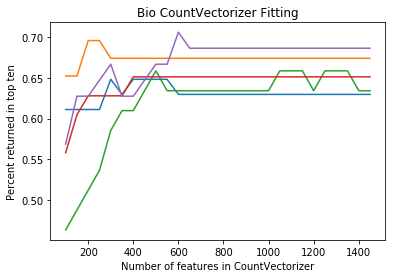

In [9]:
fig, ax = plt.subplots()
x = list(range(100,1500, 50))
for i in range(5):
    samples = test_events.sample(100)
    y = []
    for features in x:
        y.append(get_top_ten('bio', samples, features))
    plt.plot(x,y)
plt.title('Bio CountVectorizer Fitting')
plt.xlabel('Number of features in CountVectorizer')
plt.ylabel('Percent returned in top ten')
plt.savefig('CosineBioModel.pdf')
plt.show()    


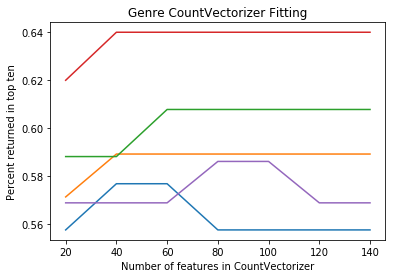

In [11]:
fig, ax = plt.subplots()
x = list(range(20,150, 20))
for i in range(5):
    samples = test_events.sample(100)
    y = []
    for features in x:
        y.append(get_top_ten('genre', samples, features))
    plt.plot(x,y)
plt.title('Genre CountVectorizer Fitting')
plt.xlabel('Number of features in CountVectorizer')
plt.ylabel('Percent returned in top ten')
plt.savefig('CosineGenreModel.pdf')
plt.show()

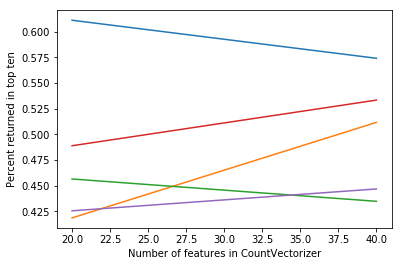

In [10]:
fig, ax = plt.subplots()
x = [20,40]
for i in range(5):
    samples = test_events.sample(100)
    y = []
    for features in x:
        y.append(get_top_ten('bio', samples, features))
    plt.plot(x,y)
plt.xlabel('Number of features in CountVectorizer')
plt.ylabel('Percent returned in top ten')
plt.savefig('CosineGenreModel.pdf') 
plt.savefig('test.pdf')
plt.show()